In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.polynomial import Polynomial
from scipy.stats import t
from typing import List

In [15]:
class PolynomialOrderAnalyzer:
    COEFF_TEXTS = {1: '(a, b)', 2: '(a, b, c)', 3: '(a, b, c, d)'}
    ORDER_TEXTS = {1: 'Linear', 2: 'Quadratic', 3: 'Cubic'}

    def __init__(self, xs, ys: np.ndarray, order: int) -> None:
        self.xs = xs
        self.ys = ys
        self.order = order
        self.df = len(self.xs) - order -1

        self.mA   = None
        self.mC   = None
        self.yp   = None
        self.diag = None
        self.MSE  = None

        # Display
        self.coeff_text = self.COEFF_TEXTS[order]
        self.order_text = self.ORDER_TEXTS[order]

    def calc_props_matrix(self) -> None:
        # Getting Prediction Series
        poly = Polynomial.fit(self.xs, self.ys, deg=self.order)
        self.mC = poly.convert().coef
        self.yp = poly(self.xs)

        # Matrix Operation
        self.mA = np.flip(np.vander(self.xs, self.order+1), axis=1)
        mAt   = self.mA.T
        mAt_A = mAt @ self.mA # gram matrix
        mI   = np.linalg.inv(mAt_A)
        self.diag = np.diag(mI)

        # Print The Statistic Properties Header
        print(f'Using polyfit : {self.order_text}')
        print(f'Coefficients  : {self.coeff_text}: '
            + f'{self.mC}')

    def calc_props_mse(self) -> None:
        # Calculate SST and SSE
        y_mean = np.mean(self.ys)
        SST = y_sq_deviation = np.sum((self.ys-y_mean) ** 2)
        SSR = np.sum((self.ys - self.yp) ** 2) # ∑ϵᵢ²
        R_squared = 1 - (SSR / SST)
        self.MSE = SSR/self.df

        print(f'\t∑(yᵢ - ŷᵢ)² : {SSR:15,.2f}')
        print(f'\tR²          : {R_squared:15,.4f}')
        print(f'\tMSE         : {self.MSE:15,.2f}')

    def calc_props_t_p_value(self) -> None:
        # t-value, p-value
        SE   = np.sqrt(self.MSE * self.diag)
        t_value = self.mC/SE
        p_value = 2 * (1 - t.cdf(abs(t_value), self.df))

        diag_formatted = [f"{x:15,.4f}" for x in self.diag]
        SE_formatted   = [f"{x:15,.4f}" for x in SE]
        t_v_formatted  = [f"{x:15,.2e}" for x in t_value]
        p_v_formatted  = [f"{x:15,.10f}" for x in p_value]
        
        print(f"diag    : [" + " ".join(diag_formatted) + "]")
        print(f"SE(β)   : [" + " ".join(SE_formatted) + "]")
        print(f"t_value : [" + " ".join(t_v_formatted) + "]")
        print(f"p_value : [" + " ".join(p_v_formatted) + "]")

In [16]:
class CurveFitting:
    def __init__(self, xs, ys : List[int]) -> None:
        # Given data
        self.xs = np.array(xs)
        self.ys = np.array(ys)

        # Seaborn styling setup
        sns.set_theme(style="whitegrid")
        self.colors = sns.color_palette("husl", 4)

    def print_props_general(self) -> None:
        y_mean = np.mean(self.ys)
        self.y_sq_deviation = np.sum((self.ys-y_mean) ** 2)
        print('General')
        print(f'\tȳ (mean)   : {y_mean:15,.2f}')
        print(f'\t∑(yᵢ-ȳ)²   : {self.y_sq_deviation:15,.2f}')
        print()

    def calc_plot_all(self) -> None:
        self.x_plot = xp = np.linspace(
            min(self.xs), max(self.xs), 100)

        # Calculate coefficients directly
        self.y1_plot = Polynomial.fit(self.xs, self.ys, deg=1)(xp)
        self.y2_plot = Polynomial.fit(self.xs, self.ys, deg=2)(xp)
        self.y3_plot = Polynomial.fit(self.xs, self.ys, deg=3)(xp)

    def add_plot_text(self, plt) -> None:
        # Add statistics for quadratic fit (example)
        poly = Polynomial.fit(self.xs, self.ys, deg=2)
        mC = poly.convert().coef
        yp = poly(self.xs)
        SST = self.y_sq_deviation
        SSR = np.sum((self.ys - yp) ** 2)
        R_squared = 1 - (SSR / SST)
        # degree = 2 → 3 params (a, b, c)
        MSE = SSR / (len(self.xs) - 3)

        # Format equation and stats
        eqn = f"$y = {mC[0]:.2f} + {mC[1]:.2f}x + {mC[2]:.2f}x^2$"
        stats_text = (
            f"$R^2 = {R_squared:.3f}$\n"
            f"$MSE = {MSE:.2f}$\n"
        )

        # Place text on plot
        plt.text(
            0.05, 0.95, 
            f"{eqn}\n{stats_text}",
            transform=plt.gca().transAxes,
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=0.8)
        )

    def plot_trend(self, plt) -> None:
        # Scatter plot with Seaborn color
        sns.scatterplot(
            x=self.xs, y=self.ys, color=self.colors[0], 
            s=100, label='Data points', edgecolor='w', linewidth=0.5)

        # Polynomial curves with Seaborn colors
        plt.plot(self.x_plot, self.y1_plot, color=self.colors[1], 
                linewidth=2.5, label='Linear fit')
        plt.plot(self.x_plot, self.y2_plot, color=self.colors[2], 
                linewidth=2.5, label='Quadratic fit')
        plt.plot(self.x_plot, self.y3_plot, color=self.colors[3], 
                linewidth=2.5, label='Cubic fit')

        plt.legend(fontsize=10, framealpha=0.9)
        plt.xlabel('x', fontsize=12)
        plt.ylabel('y', fontsize=12)
        plt.title('Polynomial Regression with Statistics')
        plt.grid(True, linestyle='--', alpha=0.3)

        plt.tight_layout()

    def draw_plot(self) -> None:
        plt.figure()
        self.plot_trend(plt)
        self.add_plot_text(plt)

        plt.tight_layout()
        plt.show()

    def process(self) -> None:
        # Print Statistical Properties
        self.print_props_general()
        
        for order in [1, 2, 3]:
            case = PolynomialOrderAnalyzer(self.xs, self.ys, order)
            case.calc_props_matrix()
            case.calc_props_mse()
            case.calc_props_t_p_value()
            print()

        self.calc_plot_all()
        self.draw_plot()

In [17]:
def main() -> int:
    # Getting Matrix Values
    mCSV = np.genfromtxt("series.csv",
      skip_header=1, delimiter=",", dtype=float)
    mCSVt   = np.transpose(mCSV)

    example = CurveFitting(mCSVt[0], mCSVt[3])
    example.process()

    return 0

General
	ȳ (mean)   :        1,115.00
	∑(yᵢ-ȳ)²   :   20,169,162.00

Using polyfit : Linear
Coefficients  : (a, b): [-721.  306.]
	∑(yᵢ - ŷᵢ)² :    3,127,410.00
	R²          :          0.8449
	MSE         :      284,310.00
diag    : [         0.2747          0.0055]
SE(β)   : [       279.4766         39.5240]
t_value : [      -2.58e+00        7.74e+00]
p_value : [   0.0255983855    0.0000089074]

Using polyfit : Quadratic
Coefficients  : (a, b, c): [ 137. -162.   39.]
	∑(yᵢ - ŷᵢ)² :       82,368.00
	R²          :          0.9959
	MSE         :        8,236.80
diag    : [         0.5165          0.0774          0.0005]
SE(β)   : [        65.2240         25.2530          2.0284]
t_value : [       2.10e+00       -6.42e+00        1.92e+01]
p_value : [   0.0620299422    0.0000768281    0.0000000032]

Using polyfit : Cubic
Coefficients  : (a, b, c, d): [5. 4. 3. 2.]
	∑(yᵢ - ŷᵢ)² :            0.00
	R²          :          1.0000
	MSE         :            0.00
diag    : [         0.7280      

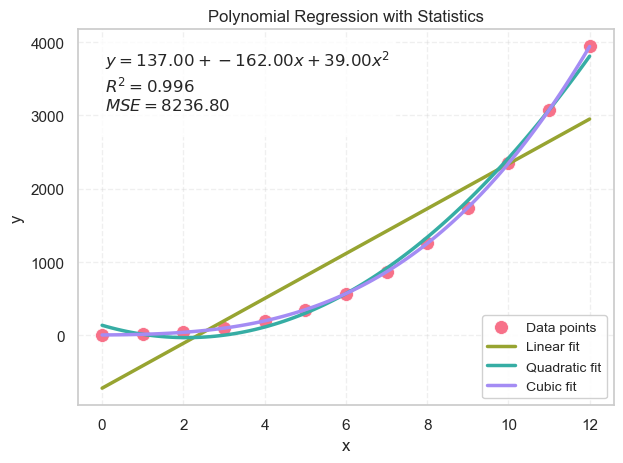

0

In [18]:
main()